# Image Segmentation of Spiral Galaxies

This notebook provides a detailed insight into the process that goes into the segmentation of spiral arms from images of spiral galaxies. This notebook accompanies the final year research project I completed for my Masters Degree in Professional Engineering (Software) at University of WA. The dataset used for this notebook is adapted from images retrieved from the 2nd public data release from the HSC data archive system, which is operated by Subaru Telescope and Astronomy Data Center at National Astronomical Observatory of Japan and classification of spiral galaxies from this dataset was achieved by [Tadaki et al.](https://arxiv.org/pdf/2006.13544.pdf) and all image content is a product of their work. You can register to access the HSC Data [here](https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/).

## [1] Install Dependencies

Here we will run the imports for packages that are used commonly throughout the notebook. Any other required packages will be imported within the code cell that they are required.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2023-07-12 12:08:52.701087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## [2] Data Pre-Processing

This section covers the functionality used to process the data prior to it being used in training the segmentation model. These functions take the images from the dataset (in the format of `.jpg` and `.tif` files) to a data format that is usable by the Tensorflow Keras API. To achieve a concise pipeline, a Keras Sequence class is used to load and vectorize the data before training the model.

### Configure Location of Data and Training Parameters

In [2]:
images_dir = "../data/images/"
masks_dir = "../data/masks_png/"
img_size = (64, 64)

val_split = 16  # % of total dataset to be used for validation
test_split = 16  # % of total dataset to be used for testing
val_batch_size = 1  # batch size per step
test_batch_size = 1
batch_size = 16

### Load Dataset and Split Into Subsets

In [3]:
images_ds = tf.keras.utils.image_dataset_from_directory(images_dir, 
                                         labels=None, 
                                         color_mode='grayscale', 
                                         shuffle=False, 
                                         image_size=img_size, 
                                         batch_size=None)

masks_ds = tf.keras.utils.image_dataset_from_directory(masks_dir, 
                                        labels=None, 
                                        color_mode='grayscale', 
                                        shuffle=False, 
                                        image_size=img_size, 
                                        batch_size=None)

dataset = tf.data.Dataset.zip((images_ds, masks_ds))

train_ds, test_ds = tf.keras.utils.split_dataset(dataset, 
                                 right_size=test_split/100, 
                                 shuffle=False)

train_ds, val_ds = tf.keras.utils.split_dataset(train_ds, 
                                 right_size=val_split/(100-test_split), 
                                 shuffle=False)

val_ds = val_ds.batch(val_batch_size)
test_ds = test_ds.batch(test_batch_size)

Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


2023-07-12 12:08:53.735232: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-07-12 12:08:53.780723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-07-12 12:08:53.780877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-07-12 12:08:53.816668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Exe

### Implement Data Augmentation Pipeline

Using in-built Keras preprocessing sequential layers, here we build a pipeline that can be used to augment the training images from the dataset.

In [4]:
def augment(image, mask):
    
    aug_model = keras.Sequential(
        layers = [
            layers.RandomFlip(mode="horizontal_and_vertical"),
            layers.RandomRotation(0.8, fill_mode="constant", interpolation='bilinear', fill_value=0),
            layers.RandomTranslation(0.2,0.2, fill_mode="constant", interpolation='bilinear', fill_value=0),
            #layers.RandomZoom((-0.01, 0.01),(-0.01, 0.01),interpolation='nearest'),
        ]
    )

    image_mask = tf.concat([image, mask], -1)
    image_mask = aug_model(image_mask)
    
    image = image_mask[:,:,:,0]
    mask = image_mask[:,:,:,1]
    
    image = tf.reshape(image, [-1, img_size[0], img_size[1], 1])
    mask = tf.reshape(mask, [-1, img_size[0], img_size[1], 1])
    
    return image, mask

aug_dataset = (
	train_ds
    .repeat()
    .batch(batch_size)
    .map(lambda img,msk: augment(img, msk))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Demonstrate Data is Loaded Correctly

The following plot should correctly display 4 examples from the augmented dataset of overlayed image segmentations.

2023-07-12 12:08:54.260962: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-12 12:08:54.267251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype float and shape [68,64,64,1]
	 [[{{node Placeholder/_5}}]]
2023-07-12 12:08:54.267530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype resource
	 [[{{node Placeholder/_14}}]]


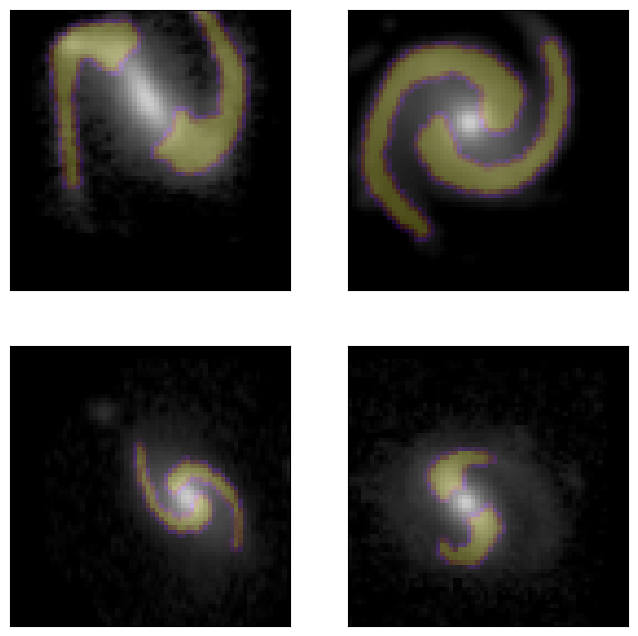

In [5]:
plt.figure(figsize=(8,8))

offset = np.random.randint(60)

for n, (image, mask) in aug_dataset.unbatch().take(4).enumerate(start=offset).as_numpy_iterator():
    
    plt.subplot(2,2,n-offset+1)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='gnuplot', alpha=0.2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### Pre-Build Augmented Data of Set Size



In [6]:
batch_size = 16
train_ds_aug = aug_dataset.unbatch().shuffle(1).take(100).batch(batch_size)

## [3] Build Model

In [7]:
def get_unet(start_neurons = 16, kernel_size=(3, 3), dropout_prob=0.2):
    
    inputs = keras.Input(shape=img_size + (1,))
    
    c1 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_prob)(p1)    

    c2 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_prob)(p2)

    c3 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    #c3 = layers.Dropout(dropout_prob)(c3)
    c3 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_prob)(p3)

    c4 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    #c4 = layers.Dropout(dropout_prob)(c4)
    c4 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = layers.Dropout(dropout_prob)(p4)

    c5 = layers.Conv2D(start_neurons*16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    #c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(start_neurons*16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(start_neurons*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropout_prob)(u6)
    c6 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    #c6 = layers.Dropout(dropout_prob)(c6)
    c6 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(start_neurons*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout_prob)(u7)
    c7 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    #c7 = layers.Dropout(dropout_prob)(c7)
    c7 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(start_neurons*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout_prob)(u8)
    c8 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(start_neurons, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropout_prob)(u9)
    c9 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return keras.Model(inputs, outputs, name='U-Net')

#get_unet(8).summary()

## [4] Train Model

In [8]:
# Ensure tensorflow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')

if(len(physical_devices) > 0):
    print(f"Number of GPUs: {len(physical_devices)}")
else:
    print("No GPU detected... Running on CPU")
    
#!nvidia-smi

No GPU detected... Running on CPU


In [9]:
import time

model = get_unet()

epochs = 10 # max number of epochs for training

"""
Augmentation factor = how many times each image is seen per training epoch
                    = steps_per_epoch*batch_size/num_training_images
    e.g. 1000*16/68 = 235.3
"""

checkpoint_dir = os.path.dirname(time.strftime('model_checkpoints/%Y%m%d_%H_%M_%S/'))
#log_dir = os.path.join('logs/fit/', checkpoint_dir, time.strftime('%Y%m%d_%H_%M_%S'))

callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, '{epoch:02d}-{val_loss:.4f}.keras'), save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True),
]

metrics = [
    keras.metrics.BinaryIoU(name='Binary IoU', threshold=0.5),
    keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
]

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
model_history = model.fit(train_ds_aug, epochs=epochs, validation_data=val_ds, verbose=1, callbacks=callbacks)

# Optional: Save history as csv
#hist_csv_file = os.path.join(checkpoint_dir, 'history.csv')
#with open(hist_csv_file, mode='w') as f:  
    #hist_df = pd.DataFrame(model_history.history)
    #hist_df.to_csv(f)

Epoch 1/10


2023-07-12 12:08:54.792928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype resource
	 [[{{node Placeholder/_10}}]]
2023-07-12 12:08:54.793193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [68,64,64,1]
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - ETA: 0s - loss: 1.8104 - Binary IoU: 0.4187 - Binary Accuracy: 0.7504

2023-07-12 12:09:00.831359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,64,64,1]
	 [[{{node Placeholder/_1}}]]


7/7 [==============================] - 7s 663ms/step - loss: 1.8104 - Binary IoU: 0.4187 - Binary Accuracy: 0.7504 - val_loss: 0.3145 - val_Binary IoU: 0.5281 - val_Binary Accuracy: 0.8540
Epoch 2/10
7/7 [==============================] - 4s 623ms/step - loss: 0.3903 - Binary IoU: 0.4901 - Binary Accuracy: 0.8548 - val_loss: 0.2060 - val_Binary IoU: 0.5053 - val_Binary Accuracy: 0.9366
Epoch 3/10
7/7 [==============================] - 4s 590ms/step - loss: 0.2470 - Binary IoU: 0.4990 - Binary Accuracy: 0.8891 - val_loss: 0.1870 - val_Binary IoU: 0.4748 - val_Binary Accuracy: 0.9461
Epoch 4/10
7/7 [==============================] - 5s 648ms/step - loss: 0.2278 - Binary IoU: 0.4945 - Binary Accuracy: 0.8928 - val_loss: 0.1447 - val_Binary IoU: 0.4758 - val_Binary Accuracy: 0.9497
Epoch 5/10
7/7 [==============================] - 4s 606ms/step - loss: 0.1740 - Binary IoU: 0.4919 - Binary Accuracy: 0.8999 - val_loss: 0.1373 - val_Binary IoU: 0.4750 - val_Binary Accuracy: 0.9499
Epoch 6/10


### Tuning Hyperparameters

In [10]:
import keras_tuner as kt

def build_model(hp):
    
    # hyper parameters
    hp_learning_rate = hp.Float("learning_rate", min_value=0.00001, max_value=0.01, sampling="log")
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])
    # hp_num_images = hp.Int("num_images", min_value=340, max_value=13600, sampling='log')
    
    model = get_unet(16, (hp_kernel_size, hp_kernel_size), 0.2)

    metrics = [
        keras.metrics.BinaryIoU(name='BinaryIoU', threshold=0.5),
        keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
    ]

    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

    return model

tuner = kt.BayesianOptimization(build_model,
                     objective=[kt.Objective("val_BinaryIoU", direction="max"), kt.Objective("val_loss", direction='min'), ],
                     max_trials=20,
                     directory='tuning',
                     project_name='spiral_segmentation_2', overwrite=False)

callbacks = [
    #keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, '{epoch:02d}-{val_loss:.4f}.keras'), save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True),
]

#tuner.search_space_summary()
#tuner.search(train_ds_aug, epochs=200, validation_data=val_ds, verbose=1, callbacks=callbacks)
#tuner.results_summary()

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

## [5] Test Model and Assess Performance

 1/16 [>.............................] - ETA: 2s

2023-07-12 12:09:44.029063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,64,64,1]
	 [[{{node Placeholder/_1}}]]


16/16 [==============================] - 1s 33ms/step


2023-07-12 12:09:44.812710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,64,64,1]
	 [[{{node Placeholder/_1}}]]


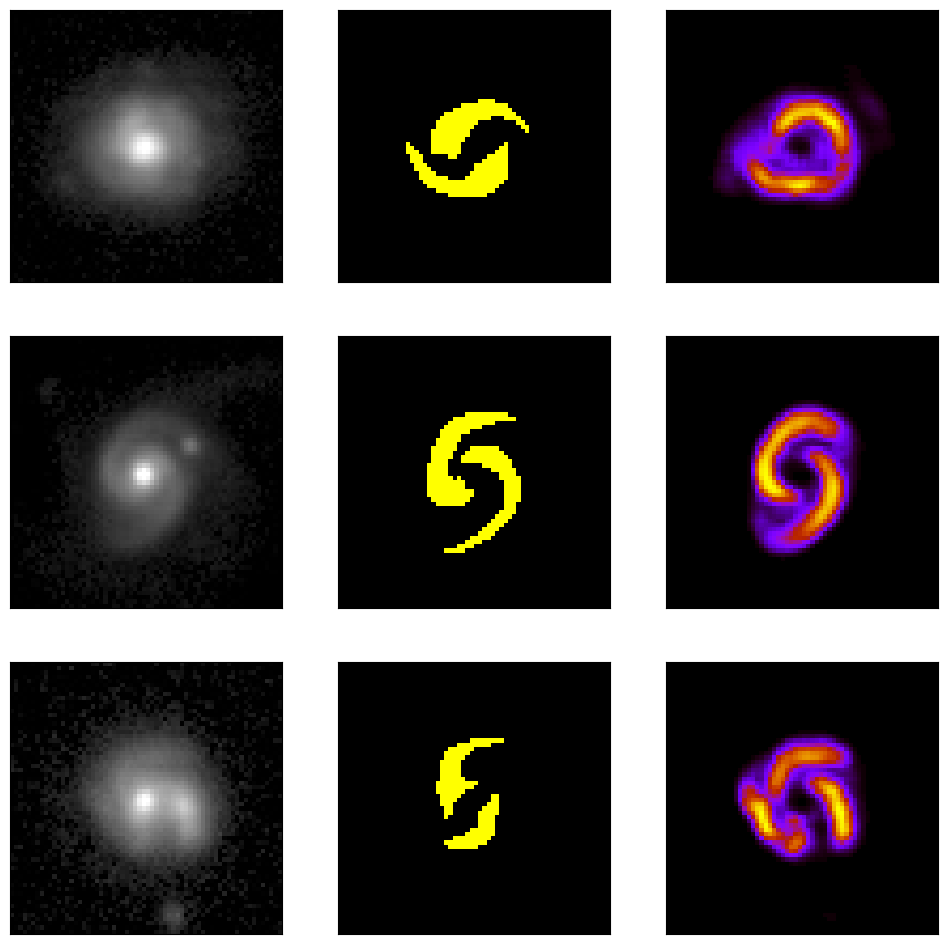

In [11]:
# For demonstration, load pre-trained model

# model = tf.keras.models.load_model('../models/tuned_model.keras')
model = tf.keras.models.load_model('../models/tuned_model_set_3.keras')

test_preds = model.predict(test_ds)
num_print = 3

plt.figure(figsize=(12,num_print*4))

for n, (gt_img, gt_mask) in enumerate(test_ds.unbatch().take(num_print)):
    
    plt.subplot(num_print,3,3*n+1)
    plt.imshow(gt_img, cmap='gray', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(num_print,3,3*n+2)
    plt.imshow(gt_mask, cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(num_print,3,3*n+3)
    plt.imshow(test_preds[n], cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
        
# For saving image:
# If directory is not already created, create it
#os.mkdir(os.path.join(checkpoint_dir, 'analysis'))
#plt.savefig(os.path.join(checkpoint_dir, 'analysis', 'test_predictions.png'))

plt.show()


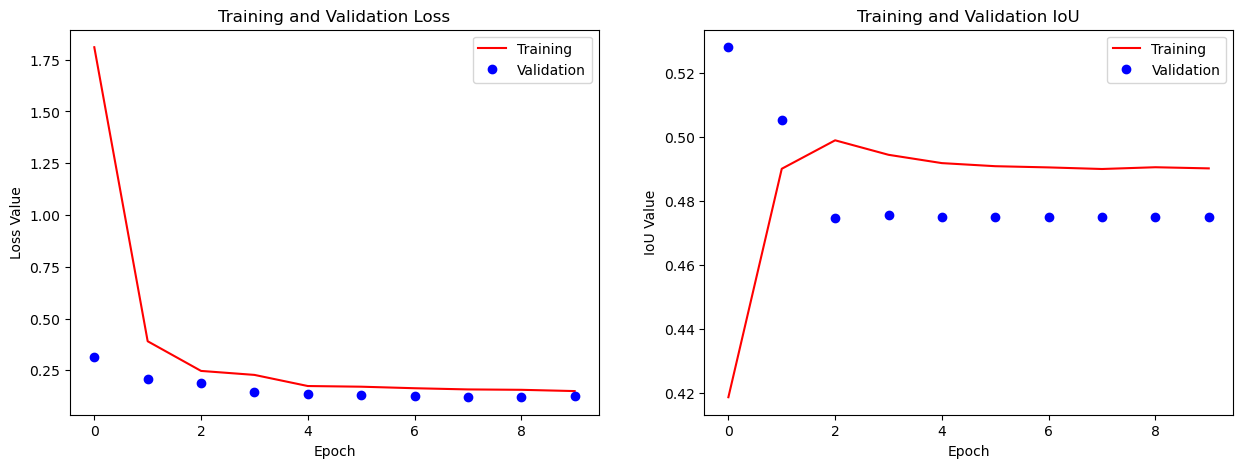

In [12]:
"""
Prints a chart of the loss and Binary IoU metrics for training the model
"""

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

epochs = range(len(model_history.history["loss"]))
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]

ax[0].plot(epochs, loss, "r", label="Training")
ax[0].plot(epochs, val_loss, "bo", label="Validation")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss Value")
ax[0].legend()

iou = model_history.history["Binary IoU"]
val_iou = model_history.history["val_Binary IoU"]

ax[1].plot(epochs, iou, "r", label="Training")
ax[1].plot(epochs, val_iou, "bo", label="Validation")
ax[1].set_title("Training and Validation IoU")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("IoU Value")
ax[1].legend()
plt.show()